In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import itertools
from collections import Counter
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from imblearn.combine import SMOTEENN
import keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load data to Panda 

In [3]:
df = pd.read_csv('../Data/clean_testing.csv', index_col=0, low_memory=False)
del df['treatment']

In [4]:
df.head()

,t0_geoip_metro_code_others_level,t0_geoip_metro_code_MC_501,t0_geoip_metro_code_MC_504,t0_geoip_metro_code_MC_506,t0_geoip_metro_code_MC_511,t0_geoip_metro_code_MC_524,t0_geoip_metro_code_MC_602,t0_geoip_metro_code_MC_618,t0_geoip_metro_code_MC_623,t0_geoip_metro_code_MC_803,...,median_hh_inc_NA,mean_hh_inc_NA,owner_occupied_hh_NA,pct_native_born_NA,pct_white_NA,pct_men_in_labor_force_NA,pct_women_in_labor_force_NA,pct_25_up_NA,ppl_per_hh_NA,pct_owner_occupied_hh_NA
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Undersampling the Non-spenders to 200000

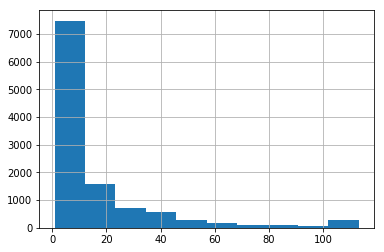

In [5]:
nonspenders = df[df.out_ltv==0]

nonspender_sampleDF = nonspenders.sample(n=200000, random_state=40)

spenderDF = df[df.out_ltv>0]

new_df = pd.concat([nonspender_sampleDF, spenderDF])

# Plot the LTV distribution for spenders only
new_df['out_ltv'][new_df['out_ltv']>0].hist();

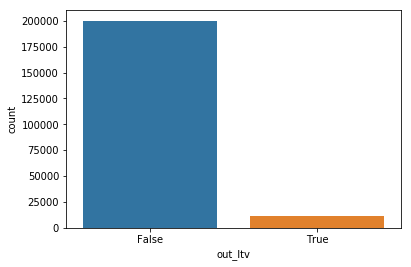

In [6]:
sns.countplot(new_df['out_ltv']>0)

In [51]:
X = np.array(new_df.drop(['out_ltv'], axis=1))
y = np.array(new_df['out_ltv'])
# y = y.values.reshape((y.shape[0],1))

seed=7
np.random.seed(seed)

# split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the training
norm_train, norm = normalize(X_train, axis=0, return_norm=True)
norm_test = X_test/norm

In [11]:
# np.save('Data/norm_train.npy', norm_train)
# np.save('Data/norm_test.npy', norm_test)
# np.save('Data/y_train.npy', y_train)
# np.save('Data/y_test.npy', y_test)

### Balance the data - by oversampling with replacement

In [54]:
train_label = y_train>0
train_label = train_label.astype(np.bool)
test_label = y_test>0
test_label = test_label.astype(np.bool)

In [55]:
seed=7
np.random.seed(seed)

# randomly select as many buyers as non_buyers from training data
sample_index = np.random.choice(len(norm_train[train_label]), size=160014)
oversampled_norm_train = np.concatenate((norm_train[train_label][sample_index], norm_train[y_train==0]), axis=0)
oversampled_y_train = np.concatenate((y_train[train_label][sample_index], y_train[y_train==0]), axis=0)

# update training label
train_label = oversampled_y_train>0
train_label = train_label.astype(np.bool)

Counter({True: 160014, False: 160014})


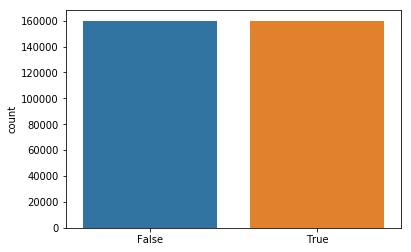

In [58]:
print(Counter(train_label))
sns.countplot(train_label);

In [59]:
# np.save('Data/oversampled_X_train', oversampled_norm_train)
# np.save('Data/overssampled_y_train', oversampled_y_train)

### Combining undersampling and oversampling using SMOTE

#### Before smoting, feature selection needs to be done. Here we use Autoencoder.

In [61]:
def rmse_(y_true, y_pred):
    return (K.mean((((y_pred-y_true))**2)))**(1/2)

# Build a FNN model with 2 hidden layers that maps input data to itself
input_data = Input(shape=(norm_train.shape[1],))
encode = Dense(128, activation='relu')(input_data)
encode2 = Dense(50, activation='relu')(encode)
decode = Dense(norm_train.shape[1])(encode2)

# This model uses all the layers. We will later use this model to evaluate
decode_model = Model(input_data, decode)

# This model uses the 2nd Dense layer to map from Dimension of input to Dimension of 50
encode_model = Model(input_data, encode2)

loss='mean_squared_error'
optimizer=Adam(lr=0.001)
metric=[rmse_]

decode_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metric)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                  factor=0.2, 
                  patience=5,   
                  epsilon=0.0001,  
                  min_lr=0)

modelchecker = ModelCheckpoint('autoencoder.h5', save_best_only=True)

earlystopper = EarlyStopping(patience=12, mode='min', verbose=1)

decode_model.fit(norm_train, 
              norm_train,
              batch_size=300, 
              epochs=50, 
              validation_split=0.2, 
              verbose=1, 
              callbacks=[reduce_lr, earlystopper, modelchecker])

Train on 135251 samples, validate on 33813 samples
Epoch 1/50
135251/135251 [==============================] - 3s - loss: 3.9387e-06 - rmse_: 0.0020 - val_loss: 3.5722e-06 - val_rmse_: 0.0019
Epoch 2/50
135251/135251 [==============================] - 3s - loss: 3.3609e-06 - rmse_: 0.0018 - val_loss: 3.3659e-06 - val_rmse_: 0.0018
Epoch 3/50
135251/135251 [==============================] - 3s - loss: 3.2059e-06 - rmse_: 0.0018 - val_loss: 3.1390e-06 - val_rmse_: 0.0018
Epoch 4/50
135251/135251 [==============================] - 3s - loss: 2.8532e-06 - rmse_: 0.0017 - val_loss: 2.7584e-06 - val_rmse_: 0.0017
Epoch 5/50
135251/135251 [==============================] - 3s - loss: 2.6143e-06 - rmse_: 0.0016 - val_loss: 2.5891e-06 - val_rmse_: 0.0016
Epoch 6/50
135251/135251 [==============================] - 3s - loss: 2.4835e-06 - rmse_: 0.0016 - val_loss: 2.4746e-06 - val_rmse_: 0.0016
Epoch 7/50
135251/135251 [==============================] - 3s - loss: 2.3928e-06 - rmse_: 0.0015 - val

In [62]:
# dimension reduction for training set
reduced_data_train = encode_model.predict(norm_train)

# dimension reduction for testing set
reduced_data_test = encode_model.predict(norm_test)

# Evaluate our model by projecting test data to itself
decode_model.evaluate(norm_test, norm_test)

42208/42266 [============================>.] - ETA: 0s

[2.2881733567348365e-06, 0.0015084358026221415]

In [67]:
# np.save('Data/autoencoded_data_train.npy', reduced_data_train)
# np.save('Data/autoencoded_data_test.npy', reduced_data_test)

### now we can smote

In [65]:
# Create new label that indicates spenders as True, non-spenders as False
label = y_train >0

side = np.hstack((reduced_data_train, y_train.reshape((y_train.shape[0],1))))
train = np.hstack((side, label.reshape((label.shape[0],1))))

# split the entire training set to 6 small subsets to avoid out of memory error
split_list = np.array_split(train, 6)

for array in split_list:
    print(Counter(array[:,-1]))

Counter({0.0: 26636, 1.0: 1542})
Counter({0.0: 26655, 1.0: 1523})
Counter({0.0: 26697, 1.0: 1480})
Counter({0.0: 26651, 1.0: 1526})
Counter({0.0: 26690, 1.0: 1487})
Counter({0.0: 26685, 1.0: 1492})


#### Smote can generate noisy data by interpolating new points between marginal outliers and inliers. This issue can be solved by cleaning the resulted space obtained after over-sampling. We choose Edited nearest-neighbours because it clears more noisy data than SmoteTomek

In [66]:
# make functions that will smote the data for us
def resample(X, y):
    sm = SMOTEENN()
    X_resampled, y_resampled = sm.fit_sample(X, y)
    return X_resampled, y_resampled

def resample_the_list(list_array):
    list_X_resampled = []
    list_y_resampled = []
    for array in list_array:
        X_resampled, y_resampled, = resample(array[:,:-1], array[:, -1].astype(np.bool))
        list_X_resampled.append(X_resampled)
        list_y_resampled.append(y_resampled)
    return list_X_resampled, list_y_resampled

In [ ]:
list_X_resampled, list_y_resampled = resample_the_list(split_list)

In [ ]:
# we will only save the X_resampled because y_resampled can be easily created by passing a booling function
final_train = np.concatenate(list_X_resampled, axis=0)
# np.save('Data/smoted_train_X_and_y.npy', final_train)